In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import time
from keras.applications import vgg16
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential,load_model
from keras.utils import to_categorical
import keras
from keras.layers import InputLayer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
data_path = '/home/vishwajeet/Documents/Summer_Project_FER/CK+_model/CK+48/'
data_dir_list = os.listdir(data_path)

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.resize(input_img,(224,224))
        img_data_list.append(input_img)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-happy

Loaded the images of dataset-anger

Loaded the images of dataset-surprise

Loaded the images of dataset-sadness

Loaded the images of dataset-disgust

Loaded the images of dataset-fear



(927, 224, 224, 3)

In [3]:
num_classes = 6

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:135]=0 #135
labels[135:312]=1 #177
labels[312:387]=2 #75
labels[387:594]=3 #207
labels[594:678]=4 #84
labels[678:927]=5 #249

# labels =to_categorical(labels, num_classes)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [4]:
input_shape=(224,224,3)
vgg = vgg16.VGG16(include_top=True, weights='imagenet', input_shape=input_shape,)

out = Dense(6, activation='softmax', name='predictions')(vgg.layers[-2].output)
vgg_model = Model(vgg.input, out)

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['predictions']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f2224dce210>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f2224e2ae50>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f227492b0d0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f2270fa0f10>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f227492b6d0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f22245b5490>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f2224dce790>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f22245c2850>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f22242afed0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f22242c2f10>,block3_conv3,False


In [5]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [6]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(img_data, labels)

10

In [7]:
import matplotlib.pyplot as plt
def cnn_model(x_train,x_test,y_test,y_train):
    model = Sequential()
    model.add(vgg_model)
    model.compile(optimizer = Adam(), loss='categorical_crossentropy', metrics=['accuracy']) 


    history=model.fit(x_train, y_train, epochs=35, batch_size=80,verbose=1)
    model.compile(loss = "categorical_crossentropy",optimizer = Adam(), metrics=['accuracy'],)

    loss,acc = model.evaluate(x_test, y_test)
    y_prediction = model.predict_classes(x_test)
    y_test_original=np.argmax(y_test,axis=1)
    confusion=confusion_matrix(y_true=y_test_original, y_pred=y_prediction)
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.title('model history')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss'], loc='upper left')
    plt.show()
    plt.plot(history.history['accuracy'])
    plt.title('model history')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy'], loc='upper left')
    plt.show()
    return acc,confusion

Epoch 1/35
832/832 [==============================] - 135s 162ms/step - loss: 1.9853 - accuracy: 0.1947
Epoch 2/35
832/832 [==============================] - 120s 144ms/step - loss: 1.7363 - accuracy: 0.3017
Epoch 3/35
832/832 [==============================] - 129s 155ms/step - loss: 1.6386 - accuracy: 0.3113
Epoch 4/35
832/832 [==============================] - 120s 144ms/step - loss: 1.5314 - accuracy: 0.3774
Epoch 5/35
832/832 [==============================] - 119s 144ms/step - loss: 1.4492 - accuracy: 0.4675
Epoch 6/35
832/832 [==============================] - 120s 144ms/step - loss: 1.4175 - accuracy: 0.4700
Epoch 7/35
832/832 [==============================] - 121s 145ms/step - loss: 1.4697 - accuracy: 0.4243
Epoch 8/35
832/832 [==============================] - 120s 144ms/step - loss: 1.4569 - accuracy: 0.4447
Epoch 9/35
832/832 [==============================] - 119s 144ms/step - loss: 1.3781 - accuracy: 0.4796
Epoch 10/35
832/832 [==============================] - 120s 144m

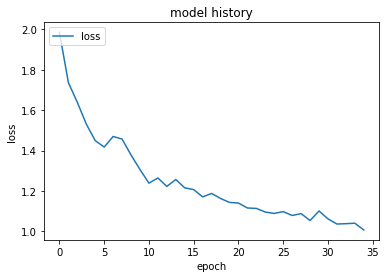

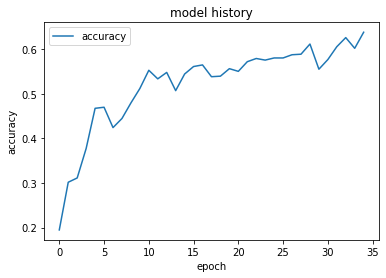

0.5263158082962036
[[ 7  0  0  0  0  7]
 [11  1  0  0  0  6]
 [ 1  2  0  0  0  5]
 [ 0  0  0 20  0  1]
 [ 1  0  0  3  0  5]
 [ 2  1  0  0  0 22]]
----------------------------
Epoch 1/35
832/832 [==============================] - 121s 145ms/step - loss: 1.1729 - accuracy: 0.5493
Epoch 2/35
832/832 [==============================] - 119s 143ms/step - loss: 1.0300 - accuracy: 0.6082
Epoch 3/35
832/832 [==============================] - 119s 143ms/step - loss: 1.0173 - accuracy: 0.6202
Epoch 4/35
832/832 [==============================] - 120s 144ms/step - loss: 1.0167 - accuracy: 0.6214
Epoch 5/35
832/832 [==============================] - 120s 144ms/step - loss: 1.0207 - accuracy: 0.6274
Epoch 6/35
832/832 [==============================] - 120s 144ms/step - loss: 1.0089 - accuracy: 0.6130
Epoch 7/35
832/832 [==============================] - 119s 144ms/step - loss: 1.0315 - accuracy: 0.5865
Epoch 8/35
832/832 [==============================] - 119s 144ms/step - loss: 0.9826 - accuracy: 

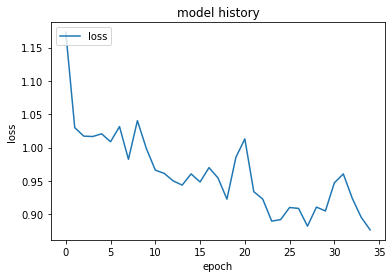

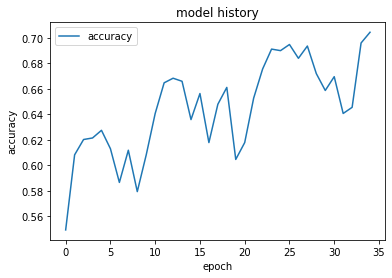

0.6000000238418579
[[13  1  0  0  0  0]
 [13  5  0  0  0  0]
 [ 0  6  0  0  2  0]
 [ 0  2  1 18  0  0]
 [ 0  2  0  1  5  1]
 [ 1  6  0  0  2 16]]
----------------------------
Epoch 1/35
832/832 [==============================] - 118s 142ms/step - loss: 1.0786 - accuracy: 0.5877
Epoch 2/35
832/832 [==============================] - 120s 144ms/step - loss: 0.9127 - accuracy: 0.6587
Epoch 3/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8600 - accuracy: 0.6995
Epoch 4/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8619 - accuracy: 0.6791
Epoch 5/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8825 - accuracy: 0.6839
Epoch 6/35
832/832 [==============================] - 119s 143ms/step - loss: 0.8529 - accuracy: 0.6959
Epoch 7/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8687 - accuracy: 0.6839
Epoch 8/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8818 - accuracy: 

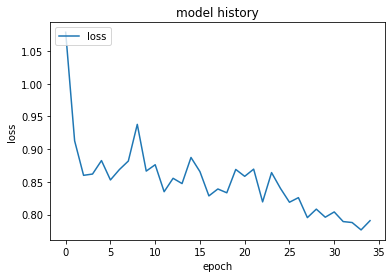

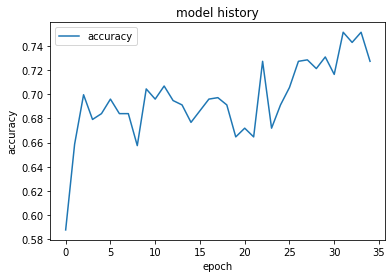

0.6000000238418579
[[ 3  1  0  0  0 10]
 [ 7  8  0  0  0  3]
 [ 0  6  0  0  1  1]
 [ 0  1  0 20  0  0]
 [ 0  2  0  0  2  5]
 [ 0  1  0  0  0 24]]
----------------------------
Epoch 1/35
832/832 [==============================] - 120s 144ms/step - loss: 0.9236 - accuracy: 0.6418
Epoch 2/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8301 - accuracy: 0.7224
Epoch 3/35
832/832 [==============================] - 119s 144ms/step - loss: 0.7994 - accuracy: 0.7284
Epoch 4/35
832/832 [==============================] - 119s 144ms/step - loss: 0.8157 - accuracy: 0.7115
Epoch 5/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8023 - accuracy: 0.7188
Epoch 6/35
832/832 [==============================] - 120s 144ms/step - loss: 0.8123 - accuracy: 0.6971
Epoch 7/35
832/832 [==============================] - 120s 144ms/step - loss: 0.7820 - accuracy: 0.7175
Epoch 8/35
832/832 [==============================] - 120s 144ms/step - loss: 0.7747 - accuracy: 

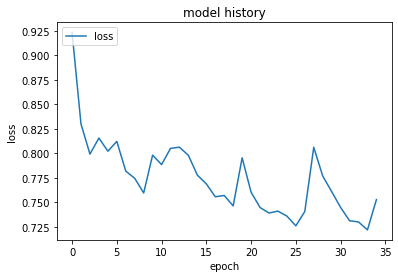

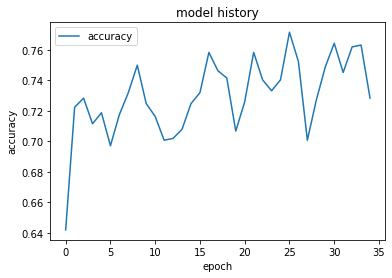

0.6105263233184814
[[ 7  0  0  0  0  7]
 [13  0  0  0  0  5]
 [ 0  2  1  1  1  3]
 [ 0  0  0 20  1  0]
 [ 0  0  0  0  6  3]
 [ 0  1  0  0  0 24]]
----------------------------
Epoch 1/35
833/833 [==============================] - 118s 141ms/step - loss: 0.8610 - accuracy: 0.6591
Epoch 2/35
833/833 [==============================] - 120s 143ms/step - loss: 0.7680 - accuracy: 0.7203
Epoch 3/35
833/833 [==============================] - 120s 144ms/step - loss: 0.7651 - accuracy: 0.7143
Epoch 4/35
833/833 [==============================] - 119s 143ms/step - loss: 0.8368 - accuracy: 0.6831
Epoch 5/35
833/833 [==============================] - 119s 143ms/step - loss: 0.7982 - accuracy: 0.7095
Epoch 6/35
833/833 [==============================] - 120s 144ms/step - loss: 0.8005 - accuracy: 0.7011
Epoch 7/35
833/833 [==============================] - 120s 144ms/step - loss: 0.7602 - accuracy: 0.7407
Epoch 8/35
833/833 [==============================] - 120s 144ms/step - loss: 0.7827 - accuracy: 

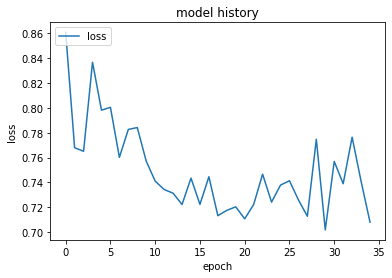

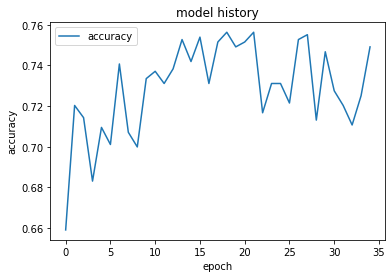

0.7446808218955994
[[ 6  7  0  0  0  1]
 [ 0 16  0  0  0  2]
 [ 0  0  2  6  0  0]
 [ 0  0  0 21  0  0]
 [ 0  6  0  0  2  0]
 [ 0  2  0  0  0 23]]
----------------------------
Epoch 1/35
835/835 [==============================] - 118s 142ms/step - loss: 0.7618 - accuracy: 0.7305
Epoch 2/35
835/835 [==============================] - 120s 144ms/step - loss: 0.7616 - accuracy: 0.7114
Epoch 3/35
835/835 [==============================] - 121s 144ms/step - loss: 0.7360 - accuracy: 0.7401
Epoch 4/35
835/835 [==============================] - 121s 145ms/step - loss: 0.7140 - accuracy: 0.7389
Epoch 5/35
835/835 [==============================] - 121s 144ms/step - loss: 0.7177 - accuracy: 0.7509
Epoch 6/35
835/835 [==============================] - 120s 144ms/step - loss: 0.6898 - accuracy: 0.7725
Epoch 7/35
835/835 [==============================] - 121s 144ms/step - loss: 0.6773 - accuracy: 0.7581
Epoch 8/35
835/835 [==============================] - 120s 144ms/step - loss: 0.6831 - accuracy: 

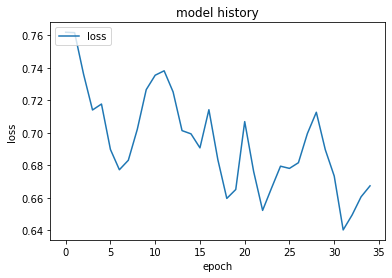

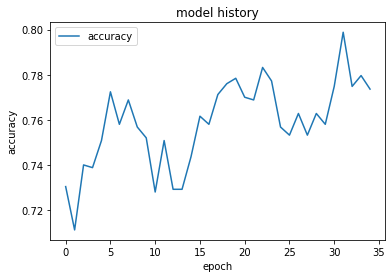

0.804347813129425
[[12  1  0  0  0  0]
 [ 0 15  0  0  1  2]
 [ 0  0  2  5  0  0]
 [ 0  1  2 17  0  1]
 [ 0  2  0  0  5  1]
 [ 0  2  0  0  0 23]]
----------------------------
Epoch 1/35
835/835 [==============================] - 118s 141ms/step - loss: 0.8682 - accuracy: 0.6587
Epoch 2/35
835/835 [==============================] - 120s 144ms/step - loss: 0.6982 - accuracy: 0.7449
Epoch 3/35
835/835 [==============================] - 120s 144ms/step - loss: 0.6814 - accuracy: 0.7533
Epoch 4/35
835/835 [==============================] - 120s 144ms/step - loss: 0.6792 - accuracy: 0.7629
Epoch 5/35
835/835 [==============================] - 120s 144ms/step - loss: 0.6711 - accuracy: 0.7749
Epoch 6/35
835/835 [==============================] - 120s 144ms/step - loss: 0.6863 - accuracy: 0.7425
Epoch 7/35
835/835 [==============================] - 120s 144ms/step - loss: 0.7034 - accuracy: 0.7461
Epoch 8/35
835/835 [==============================] - 120s 144ms/step - loss: 0.6546 - accuracy: 0

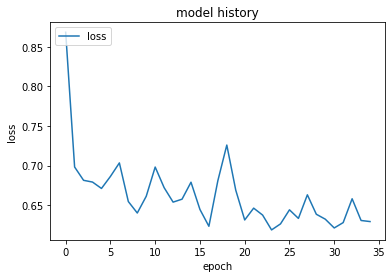

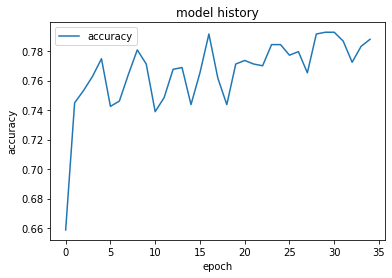

0.8152173757553101
[[11  2  0  0  0  0]
 [ 0 16  0  0  0  2]
 [ 0  0  0  7  0  0]
 [ 0  0  0 21  0  0]
 [ 0  2  1  0  5  0]
 [ 0  3  0  0  0 22]]
----------------------------
Epoch 1/35
837/837 [==============================] - 118s 141ms/step - loss: 0.7712 - accuracy: 0.6834
Epoch 2/35
837/837 [==============================] - 121s 144ms/step - loss: 0.6589 - accuracy: 0.7443
Epoch 3/35
837/837 [==============================] - 120s 144ms/step - loss: 0.6144 - accuracy: 0.7921
Epoch 4/35
837/837 [==============================] - 120s 143ms/step - loss: 0.6244 - accuracy: 0.7730
Epoch 5/35
837/837 [==============================] - 120s 144ms/step - loss: 0.6217 - accuracy: 0.7921
Epoch 6/35
837/837 [==============================] - 121s 144ms/step - loss: 0.6124 - accuracy: 0.7921
Epoch 7/35
837/837 [==============================] - 121s 145ms/step - loss: 0.6224 - accuracy: 0.7742
Epoch 8/35
837/837 [==============================] - 121s 144ms/step - loss: 0.6210 - accuracy: 

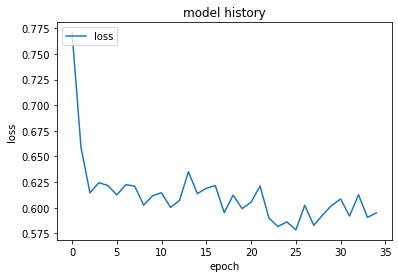

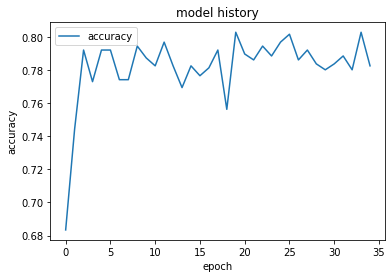

0.7888888716697693
[[ 8  5  0  0  0  0]
 [ 0 14  1  0  2  0]
 [ 0  0  0  6  0  1]
 [ 0  0  0 20  0  0]
 [ 0  2  0  0  6  0]
 [ 1  1  0  0  0 23]]
----------------------------
Epoch 1/35
837/837 [==============================] - 119s 143ms/step - loss: 0.7544 - accuracy: 0.7240
Epoch 2/35
837/837 [==============================] - 121s 145ms/step - loss: 0.6382 - accuracy: 0.7646
Epoch 3/35
837/837 [==============================] - 122s 146ms/step - loss: 0.5906 - accuracy: 0.7933
Epoch 4/35
837/837 [==============================] - 122s 146ms/step - loss: 0.5848 - accuracy: 0.7730
Epoch 5/35
837/837 [==============================] - 122s 146ms/step - loss: 0.5989 - accuracy: 0.7969
Epoch 6/35
837/837 [==============================] - 122s 146ms/step - loss: 0.6039 - accuracy: 0.7849
Epoch 7/35
837/837 [==============================] - 122s 146ms/step - loss: 0.5895 - accuracy: 0.7873
Epoch 8/35
837/837 [==============================] - 122s 145ms/step - loss: 0.5884 - accuracy: 

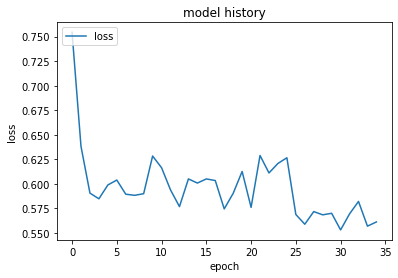

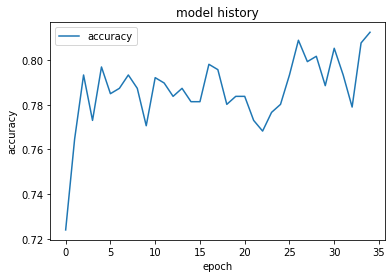

0.8111110925674438
[[ 9  4  0  0  0  0]
 [ 0 16  0  0  0  1]
 [ 0  0  0  7  0  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  1  7  0]
 [ 1  0  0  3  0 21]]
----------------------------
Epoch 1/35
838/838 [==============================] - 120s 143ms/step - loss: 0.6242 - accuracy: 0.7685
Epoch 2/35
838/838 [==============================] - 123s 146ms/step - loss: 0.5621 - accuracy: 0.8019
Epoch 3/35
838/838 [==============================] - 123s 146ms/step - loss: 0.5801 - accuracy: 0.7745
Epoch 4/35
838/838 [==============================] - 122s 146ms/step - loss: 0.5496 - accuracy: 0.8055
Epoch 5/35
838/838 [==============================] - 122s 146ms/step - loss: 0.5338 - accuracy: 0.8198
Epoch 6/35
838/838 [==============================] - 122s 146ms/step - loss: 0.5378 - accuracy: 0.8186
Epoch 7/35
838/838 [==============================] - 122s 146ms/step - loss: 0.5334 - accuracy: 0.8174
Epoch 8/35
838/838 [==============================] - 123s 147ms/step - loss: 0.5604 - accuracy: 

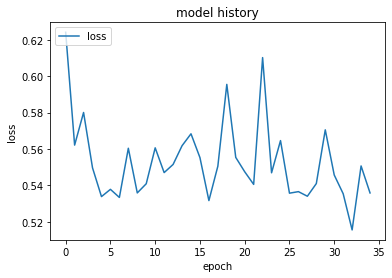

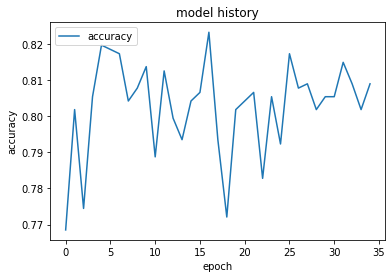

0.7528089880943298
[[ 9  3  0  0  0  1]
 [ 0 10  3  0  1  3]
 [ 0  0  4  3  0  0]
 [ 0  0  1 16  1  2]
 [ 0  0  1  0  4  3]
 [ 0  0  0  0  0 24]]
----------------------------


In [8]:
prediction=[]
confusion_list=[]
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
num_classes = 6
for train_index, test_index in skf.split(img_data, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    x_train=x_train.reshape(x_train.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT,3)
    x_test=x_test.reshape(x_test.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT,3)
    y_train =to_categorical(y_train, num_classes)
    y_test =to_categorical(y_test, num_classes)
    X,Y=cnn_model(x_train,x_test,y_test,y_train)
    prediction.append(X)
    confusion_list.append(Y)
    print(X)
    print(Y)
    print("----------------------------")

In [9]:
print(prediction)

[0.5263158082962036, 0.6000000238418579, 0.6000000238418579, 0.6105263233184814, 0.7446808218955994, 0.804347813129425, 0.8152173757553101, 0.7888888716697693, 0.8111110925674438, 0.7528089880943298]
